In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
import os
import networkx as nx
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from page import pagerank
from deepwalk_generate import DpWalk
from processing_abstract import process_abstracts
from process_authorFile import process_authorFiles
from final_dico_creation import dictionary_concatenation
from Text_Embedding import Embed_Author
import pickle
from MLP import prepare_data, MLP, train_model, evaluate_model, predict
import nltk
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
# nltk.download('punkt')
#*** use python -m nltk.downloader punkt ****
from nltk.tokenize import word_tokenize
print("All libraries imported.")

All libraries imported.


In [ ]:
print("loading training data")
# read training data
df_train = pd.read_csv(
    'data/train.csv', dtype={'author': np.int64, 'hindex': np.float32})
n_train = df_train.shape[0]

print("loading test data")
# read test data
df_test = pd.read_csv('data/test.csv', dtype={'author': np.int64})
n_test = df_test.shape[0]

print("loading graph")
# load the graph
G = nx.read_edgelist('data/coauthorship.edgelist', delimiter=' ', nodetype=int)
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

# computes structural features for each node
print("loading core_number")
infile = open('features/coreNumber.pkl', 'rb')
core_number = pickle.load(infile)
infile.close()

#node centrality
print("loading centrality")
infile = open('features/centrality.pkl', 'rb')
centrality = pickle.load(infile)
infile.close()

#Clustering Coefficient
print("loading Clustering Coefficient")
infile = open('features/ClusteringCoefficient.pkl', 'rb')
cc = pickle.load(infile)
infile.close()

#computes the page rank
print("calculating Page rank")
infile = open('features/PageRank.pkl', 'rb')
pr = pickle.load(infile)
infile.close()

print("loading DeepWalk mapping")
infile = open('features/mapping.pkl', 'rb')
mapping = pickle.load(infile)
infile.close()

print("loading DeepWalk")
infile = open('features/deepWalk.pkl', 'rb')
dw = pickle.load(infile)
infile.close()
print("type(dw) : ", type(dw))
print("len(dw) = ", len(dw))

print("generating word embeddings")
infile = open('features/fullEmbeddings_random.pkl', 'rb')
AllAuthorEmbeddings = pickle.load(infile)
infile.close()

infile = open('data/DictForAuthor_new.pkl', 'rb')
DictForAuthor_new = pickle.load(infile)
infile.close()

AuthorEmbedding = {}
counter = 0
for author in DictForAuthor_new:
    AuthorEmbedding[float(author)] = AllAuthorEmbeddings[counter]
    counter = counter+1


In [ ]:
print("set up train features")
X_train = np.zeros((n_train, 768+5+64))
y_train = np.zeros(n_train)
for i, row in df_train.iterrows():
    node = row['author']
    X_train[i, :768] = AuthorEmbedding[node]
    X_train[i, 768] = G.degree(node)
    X_train[i, 769] = core_number[node]
    X_train[i, 770] = pr[node]
    X_train[i, 771] = centrality[node]
    X_train[i, 772] = cc[node]
    X_train[i, 773:837] = dw[mapping[node]]
    y_train[i] = row['hindex']

print("set up test features")
X_test = np.zeros((n_test, 768+5+64))
for i, row in df_test.iterrows():
    node = row['author']
    X_test[i, :768] = AuthorEmbedding[node]
    X_test[i, 768] = G.degree(node)
    X_test[i, 769] = core_number[node]
    X_test[i, 770] = pr[node]
    X_test[i, 771] = centrality[node]
    X_test[i, 772] = cc[node]
    X_test[i, 773:837] = dw[mapping[node]]

In [ ]:
print("creating model")

reg = MLPRegressor(
    # hidden_layer_sizes=(559),  # rule of thumb: (num inputs + 1) * (2/3)
    # hidden_layer_sizes=(250, 20),
    hidden_layer_sizes=(150, 200, 100, 30),
    # hidden_layer_sizes=(150, 200, 100, 50, 15),
    learning_rate_init=0.001,
    activation='relu',
    max_iter=60,
    random_state=2,
    verbose=True
)

print("fitting")
reg.fit(X_train, y_train)

print("getting predictions")
y_pred = reg.predict(X_test)

In [ ]:
###############
print("Save graph data")
loss_arr = reg.loss_curve_
with open("./graph_data/validation_loss.pkl", 'wb') as f:
    pickle.dump(loss_arr, f)
f.close()

x_axis = np.arange(len(loss_arr))
print("len(reg.loss_curve_) = ", len(reg.loss_curve_))

plt.figure(figsize=(10, 6))
plt.title("Loss graph", weight='bold', fontsize=14)
plt.grid(linestyle='--', alpha=0.2)
plt.xlabel(xlabel='number of epochs')
plt.ylabel(ylabel='validation loss')
plt.plot(x_axis, loss_arr, linewidth=2)
plt.show()
plt.savefig('./graph_data/validation_loss_graph.png')
###############


In [ ]:
print("write the predictions to file")
# write the predictions to file
df_test['hindex'] = pd.Series(np.round_(y_pred, decimals=3))


df_test.loc[:, ["author", "hindex"]].to_csv('submission.csv', index=False)
print("All operations finished.")


../graph_data/graph_3hiddenlayers_100hiddenlayersneurons.pkl
3
100
../graph_data/graph_2hiddenlayers_270hiddenlayersneurons.pkl
2
270
../graph_data/graph_1hiddenlayers_559hiddenlayersneurons.pkl
1
559
../graph_data/graph60iters_deepWalk128layers.pkl


../graph_data/graph_5hiddenlayers_515hiddenlayersneurons.pkl
5
515
../graph_data/graph_4hiddenlayers_480hiddenlayersneurons.pkl
4
480
Done.


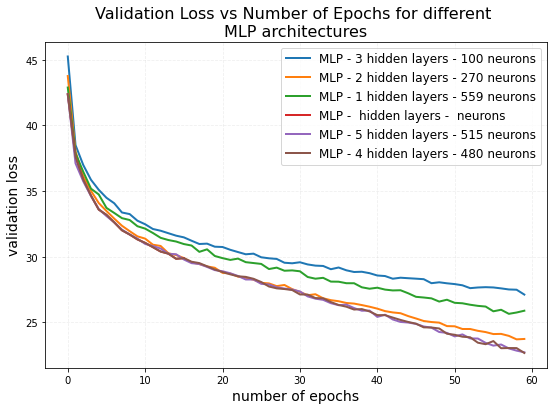

In [2]:
plt.figure(figsize=(9, 6))
plt.title("Validation Loss vs Number of Epochs for different \nMLP architectures", fontsize=16)
plt.grid(linestyle='--', alpha=0.2)
plt.xlabel(xlabel='number of epochs', fontsize=14)
plt.ylabel(ylabel='validation loss', fontsize=14)
ext = '.pkl'; dirname = '../graph_data/'
for files in os.listdir(dirname):
    if files.endswith(ext):
        print(f"{dirname}{files}")
        infile = open(f"{dirname}{files}", 'rb')
        # varname = files[:-4]
        valLossData = pickle.load(infile)
        infile.close()
        x_axis = np.arange(len(valLossData))
        numhiddenlayers = files[6:-39]
        numhiddenlayersneurons = files[20:-23]
        print(numhiddenlayers); print(numhiddenlayersneurons)
        plt.plot(x_axis, valLossData, linewidth=2, label=f"MLP - {numhiddenlayers} hidden layers - {numhiddenlayersneurons} neurons")
    else:
        continue

print("Done.")

# with open("./graph_data/validation_loss.pkl", 'wb') as f:
#     pickle.dump(loss_arr, f)
# f.close()

# x_axis = np.arange(len(loss_arr))
# print("len(reg.loss_curve_) = ", len(reg.loss_curve_))
plt.legend(fontsize=12)
plt.savefig('../graph_data/validation_loss_MLP_graph.png', dpi=300)
plt.show()
